In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas.util.testing as tm

C:\Users\saras\anaconda3\envs\tensorflow_2.1\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
import csv
import itertools

f = open('train_input.txt') 
n = sum(1 for line in open('train_input.txt'))
lines = f.readlines()
for i in range(n):
    if len(lines[i].split(','))>97:
      print(len(lines[i].split(',')))

In [7]:
from numpy import genfromtxt

my_data = genfromtxt('train_input.txt', delimiter=',')

In [8]:
tf.keras.utils.normalize(
    my_data, axis=-1, order=2
)

array([[0.101578  , 0.10158128, 0.10159617, ..., 0.10140595, 0.10143126,
        0.10143126],
       [0.10207225, 0.10207225, 0.10207225, ..., 0.10107636, 0.10128722,
        0.10128722],
       [0.10139155, 0.1015782 , 0.10156178, ..., 0.10085981, 0.10071466,
        0.10072376],
       ...,
       [0.10179205, 0.10179807, 0.1018056 , ..., 0.10155205, 0.10156836,
        0.10152483],
       [0.1015354 , 0.101559  , 0.10156939, ..., 0.10149787, 0.10143711,
        0.1013596 ],
       [0.10293761, 0.10287304, 0.1028678 , ..., 0.10088499, 0.10088521,
        0.1007228 ]])

In [9]:
df1=pd.DataFrame(my_data)

In [10]:
dfLabels = pd.read_csv("train_labels.txt",delimiter=',', names = {'Class'})
dfLabels.to_csv('train_labels.csv')

In [11]:
print(dfLabels.shape)
dfLabels.head()

(36000, 1)


,Class
0,0
1,0
2,1
3,0
4,1


In [12]:
frames = [df1, dfLabels]

In [13]:
df = pd.concat(frames, axis=1, join='outer')

In [14]:
print(df.shape)
df.head()

(36000, 98)


,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,Class
0,8666.89,8667.17,8668.44,8669.02,8669.99,8668.19,8666.94,8663.20,8667.55,8667.11,...,8658.02,8658.77,8657.32,8656.90,8656.26,8652.25,8652.21,8654.37,8654.37,0
1,7149.99,7149.99,7149.99,7149.98,7149.85,7149.85,7149.85,7140.03,7141.98,7149.93,...,7100.01,7100.01,7100.01,7100.00,7080.18,7080.18,7080.23,7095.00,7095.00,0
2,4568.59,4577.00,4576.26,4575.08,4577.89,4582.00,4581.92,4583.18,4586.47,4581.76,...,4524.78,4528.17,4530.00,4543.41,4536.01,4543.50,4544.63,4538.09,4538.50,1
3,11825.67,11819.08,11822.95,11820.47,11806.75,11793.46,11799.07,11813.74,11816.46,11815.96,...,11752.62,11769.85,11774.65,11773.01,11777.99,11789.87,11788.03,11781.00,11787.04,0
4,6379.00,6379.00,6378.99,6391.99,6391.99,6390.00,6390.00,6389.99,6388.98,6388.98,...,6424.99,6424.99,6424.67,6423.87,6420.97,6419.97,6419.98,6425.88,6425.88,1


In [15]:
print(df.Class.value_counts())

 0    22582
 1     6795
-1     6623
Name: Class, dtype: int64


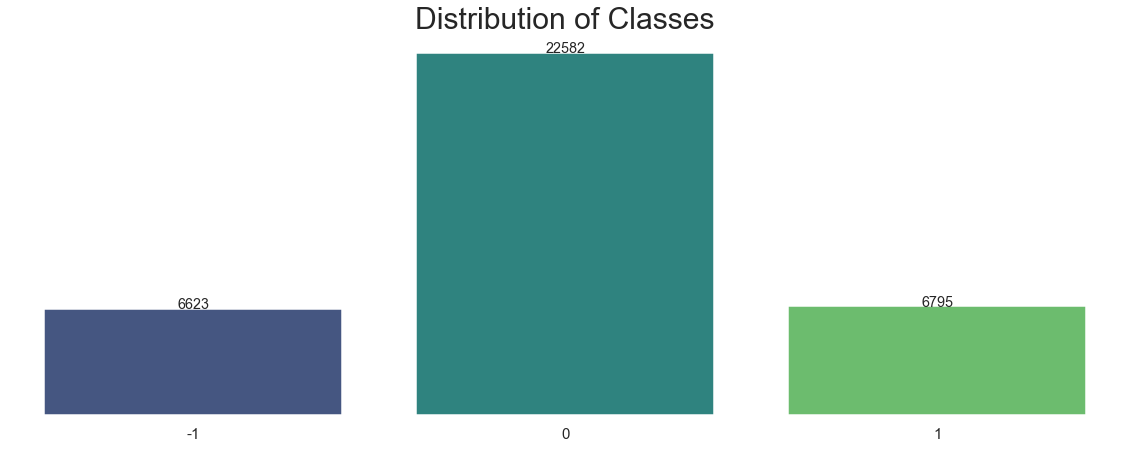

In [16]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['-1', '0','1'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Classes', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [17]:
df.isnull().any().sum()>0 #check for missing values

False

In [21]:
# baseline model and test harness for the glass identification dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier

In [22]:
# Prepare data for modeling
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [23]:
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [19]:
# define the reference model
model = DummyClassifier(strategy='most_frequent')
# evaluate the model
scores = evaluate_model(X_train, y_train, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.631 (0.000)


In [20]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

In [21]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.5925555555555555

In [22]:
knn = KNeighborsClassifier().fit(X_train, y_train)

# predict on test set
knn_pred = knn.predict(X_test)

accuracy_score(y_test, knn_pred)

0.6006666666666667

In [23]:
from sklearn.utils import resample

In [24]:
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [25]:
X = pd.concat([X_train, y_train], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,Class
7455,6485.23,6486.01,6500.23,6493.56,6495.58,6493.81,6496.40,6498.18,6497.99,6498.99,...,6524.02,6521.38,6523.49,6519.16,6515.71,6517.86,6516.01,6518.73,6517.05,-1
25509,10302.47,10311.93,10309.96,10299.57,10304.83,10317.95,10321.82,10327.45,10320.74,10322.65,...,10347.77,10337.82,10335.86,10330.14,10335.33,10345.27,10336.33,10338.48,10330.86,0
28119,10300.70,10305.04,10305.74,10287.85,10282.07,10279.40,10279.19,10285.32,10302.12,10300.53,...,10254.26,10257.78,10258.78,10257.33,10258.28,10262.04,10265.61,10265.56,10266.00,0
28231,10615.00,10596.94,10552.39,10522.00,10549.17,10517.04,10513.00,10495.00,10490.04,10464.96,...,10642.51,10664.99,10650.98,10661.05,10663.98,10664.55,10659.78,10655.00,10642.00,-1
18875,4771.98,4771.97,4762.19,4771.98,4771.98,4771.98,4771.98,4771.99,4772.00,4772.00,...,4776.93,4776.93,4776.93,4774.26,4774.26,4774.26,4776.93,4776.93,4787.97,-1


In [27]:
# separate minority and majority classes
not_changed = X[X.Class==0]
more = X[X.Class==1]
less = X[X.Class==(-1)]
# upsample minority
more_upsampled = resample(more,
                          replace=True, # sample with replacement
                          n_samples=len(not_changed), # match number in majority class
                          random_state=1) # reproducible results

less_upsampled = resample(less,
                          replace=True, # sample with replacement
                          n_samples=len(not_changed), # match number in majority class
                          random_state=1) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_changed, more_upsampled, less_upsampled])
# combine majority and upsampled minority
upsampled.Class.value_counts()

-1    17027
 1    17027
 0    17027
Name: Class, dtype: int64

In [28]:
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

In [29]:
knn = KNeighborsClassifier().fit(X_train, y_train)

# predict on test set
knn_pred = knn.predict(X_test)

accuracy_score(y_test, knn_pred)

0.4978888888888889

In [30]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.566

In [31]:
# define the reference model
model = DummyClassifier(strategy='most_frequent')
# evaluate the model
scores = evaluate_model(X_train, y_train, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.333 (0.000)


In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE('minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

C:\Users\saras\anaconda3\envs\tensorflow_2.1\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


(51081, 97) (51081,)


In [33]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_sm, y_sm)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.5597777777777778

In [34]:
knn = KNeighborsClassifier().fit(X_sm, y_sm)

# predict on test set
knn_pred = knn.predict(X_test)

accuracy_score(y_test, knn_pred)

0.4978888888888889

In [35]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_changed_downsampled = resample(not_changed,
                                replace = False, # sample without replacement
                                n_samples = len(more), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_changed_downsampled, more, less])

# checking counts
downsampled.Class.value_counts()

 1    5100
 0    5100
-1    4873
Name: Class, dtype: int64

In [36]:
y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

In [37]:
knn = KNeighborsClassifier().fit(X_train, y_train)

# predict on test set
knn_pred = knn.predict(X_test)

accuracy_score(y_test, knn_pred)

0.5063333333333333

In [38]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.46155555555555555

In [39]:
# define the reference model
model = DummyClassifier(strategy='most_frequent')
# evaluate the model
scores = evaluate_model(X_train, y_train, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.338 (0.000)


In [40]:
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [41]:
X = pd.concat([X_train, y_train], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,Class
7455,6485.23,6486.01,6500.23,6493.56,6495.58,6493.81,6496.40,6498.18,6497.99,6498.99,...,6524.02,6521.38,6523.49,6519.16,6515.71,6517.86,6516.01,6518.73,6517.05,-1
25509,10302.47,10311.93,10309.96,10299.57,10304.83,10317.95,10321.82,10327.45,10320.74,10322.65,...,10347.77,10337.82,10335.86,10330.14,10335.33,10345.27,10336.33,10338.48,10330.86,0
28119,10300.70,10305.04,10305.74,10287.85,10282.07,10279.40,10279.19,10285.32,10302.12,10300.53,...,10254.26,10257.78,10258.78,10257.33,10258.28,10262.04,10265.61,10265.56,10266.00,0
28231,10615.00,10596.94,10552.39,10522.00,10549.17,10517.04,10513.00,10495.00,10490.04,10464.96,...,10642.51,10664.99,10650.98,10661.05,10663.98,10664.55,10659.78,10655.00,10642.00,-1
18875,4771.98,4771.97,4762.19,4771.98,4771.98,4771.98,4771.98,4771.99,4772.00,4772.00,...,4776.93,4776.93,4776.93,4774.26,4774.26,4774.26,4776.93,4776.93,4787.97,-1


In [42]:
# separate minority and majority classes
not_changed = X[X.Class==0]
more = X[X.Class==1]
less = X[X.Class==(-1)]
# upsample minority
more_upsampled = resample(more,
                          replace=True, # sample with replacement
                          n_samples=len(not_changed), # match number in majority class
                          random_state=100) # reproducible results

less_upsampled = resample(less,
                          replace=True, # sample with replacement
                          n_samples=len(not_changed), # match number in majority class
                          random_state=100) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_changed, more_upsampled, less_upsampled])
# combine majority and upsampled minority
upsampled.Class.value_counts()

-1    17027
 1    17027
 0    17027
Name: Class, dtype: int64

In [43]:
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from keras.utils import to_categorical

y1 = upsampled.Class
y2 = y1+1
y = to_categorical(y2)

X1 = upsampled.drop('Class', axis=1)
X = np.array(X1)

Using TensorFlow backend.


In [45]:
#rescaling the data
mean = np.mean(X, axis=1, keepdims = True)
std = np.std(X, axis=1, keepdims = True)
X = (X - mean)/std

In [27]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df, train_labels, test_labels = train_test_split(X, y, test_size=0.2)

In [28]:
from sklearn import preprocessing
import keras

def make_model(output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Dense(
          1024, activation='relu',
          input_shape=(train_df.shape[-1],)),
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dense(256, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      tensorflow.keras.layers.Dense(128, activation='relu'),
      tensorflow.keras.layers.Dense(64, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      tensorflow.keras.layers.Dense(32, activation='relu'),
      tensorflow.keras.layers.Dense(3, activation='softmax',
                         bias_initializer=output_bias),
  ])

  model.compile(
    optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.5),
    loss=tensorflow.keras.losses.categorical_crossentropy,
    metrics=[tf.keras.metrics.Accuracy()])
    
  return model

Using TensorFlow backend.


In [29]:
EPOCHS = 100
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [30]:
model = make_model()
model.summary()

NameError: name 'tensorflow' is not defined

In [32]:
model.fit(train_df, train_labels,
         batch_size=BATCH_SIZE,
         epochs=EPOCHS,
         verbose=2,
         validation_split=0.2)

NameError: name 'model' is not defined

In [ ]:
y_val_pred = model.predict(val_df)
y_val_pred = np.argmax(y_val_pred, axis=1)
y_val_test = np.argmax(val_labels, axis=1)

In [ ]:
from sklearn import metrics

print(metrics.accuracy_score(y_val_test, y_val_pred))

In [ ]:
metrics.confusion_matrix(y_val_test, y_val_pred, labels=None, sample_weight=None, normalize=None)

In [73]:
y_pred = model.predict(test_df)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(test_labels, axis=1)

In [79]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred))

0.8228442791426055


In [26]:
metrics.confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)

NameError: name 'metrics' is not defined

In [81]:
df = pd.read_csv("test_input.txt",delimiter=',', header=None)
df.to_csv('test_input.csv')

In [82]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,11341.49,11342.36,11333.20,11340.00,11349.37,11334.93,11352.20,11365.85,11356.80,11360.33,...,11415.53,11421.40,11432.86,11422.43,11437.32,11407.88,11365.64,11366.18,11340.00,11370.23
1,6281.00,6282.99,6282.99,6282.72,6283.04,6287.37,6287.10,6287.13,6291.42,6289.46,...,6273.01,6276.22,6273.48,6277.87,6276.15,6276.89,6282.53,6279.01,6278.84,6278.00
2,8104.65,8104.49,8104.28,8099.99,8098.07,8090.24,8080.00,8087.65,8087.65,8107.59,...,8152.07,8151.48,8149.36,8147.93,8156.03,8157.01,8160.04,8158.04,8164.96,8165.01
3,7269.95,7273.43,7268.77,7273.98,7271.92,7274.08,7279.98,7279.22,7281.78,7282.18,...,7365.76,7370.75,7369.15,7373.47,7371.49,7365.23,7358.29,7360.00,7361.40,7357.01
4,4347.06,4347.06,4347.06,4348.04,4348.04,4348.04,4359.88,4359.88,4359.88,4359.88,...,4342.23,4336.01,4342.23,4342.23,4336.01,4336.01,4336.01,4336.01,4336.01,4348.45


In [83]:
X1 = np.array(df)
mean1 = np.mean(X1, axis=1, keepdims = True)
std1 = np.std(X1, axis=1, keepdims = True)
x_test = (X1 - mean1)/std1

In [87]:
y_pred1 = model.predict(x_test)

In [88]:
y_pred1 = np.argmax(y_pred1, axis=1)

In [90]:
y_pred_labels=y_pred1-1

In [93]:
np.savetxt('test_labels.txt', y_pred_labels, delimiter=',', fmt='%i')